In [1]:
import numpy as np
from src.cyc_gbm import CycGBM
from src.cyc_gbm.utils import tune_kappa, train_test_split
from src.cyc_gbm.distributions import initiate_distribution
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
# Simulation parameters
n = 100000
p = 9
dist = "normal"
simulation_seed = 10
cv_seed = 11


def parameter_function(X):
    z0 = (
        1.5 * X[:, 1]
        + 2 * X[:, 3]
        - 0.65 * X[:, 2] ** 2
        + 0.5 * np.abs(X[:, 3]) * np.sin(0.5 * X[:, 2])
        + 0.45 * X[:, 4] * X[:, 5] ** 2
    )
    z1 = 1 + 0.02 * X[:, 2] + 0.5 * X[:, 1] * (X[:, 1] < 2) + 1.8 * (X[:, 5] > 0)
    return np.stack([z0, z1])


# Set hyperparameters
kappa_max = 250
eps = 0.1
max_depth = 3
min_samples_leaf = 5
n_splits = 10

## Simulate data

In [3]:
rng = np.random.default_rng(seed=simulation_seed)
X = np.concatenate([np.ones((1, n)), rng.normal(0, 1, (p - 1, n))]).T

distribution = initiate_distribution(dist=dist)
z = parameter_function(X)
y = distribution.simulate(z=z, rng=rng)
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(
    X=X, y=y, z=z, test_size=0.2, rng=rng
)
z_hat = {"train": {"true": z_train}, "test": {"true": z_test}}

### Univariate GBM

In [4]:
# Tune kappa
kappa_uni = tune_kappa(
    X=X_train,
    y=y_train,
    n_splits=n_splits,
    eps=eps,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    kappa_max=[kappa_max, 0],
    dist=dist,
    random_state=cv_seed,
    verbose=1,
)["kappa"]

gbm_uni = CycGBM(
    kappa=kappa_uni,
    dist="normal",
    eps=eps,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
)
gbm_uni.fit(X_train, y_train)

z_hat["train"]["uni-gbm"] = gbm_uni.predict(X_train)
z_hat["test"]["uni-gbm"] = gbm_uni.predict(X_test)

2023-04-27 15:03:09,027 - src.cyc_gbm.utils - INFO - Starting tuning of kappa with 10-fold cross-validation
2023-04-27 15:03:09,028 - src.cyc_gbm.utils - INFO - Fold 1/10
2023-04-27 15:03:17,368 - src.cyc_gbm.utils - INFO - Fold 2/10
2023-04-27 15:03:27,632 - src.cyc_gbm.utils - INFO - Fold 3/10
2023-04-27 15:03:35,577 - src.cyc_gbm.utils - INFO - Fold 4/10
2023-04-27 15:03:42,455 - src.cyc_gbm.utils - INFO - Fold 5/10
2023-04-27 15:03:51,658 - src.cyc_gbm.utils - INFO - Fold 6/10
2023-04-27 15:03:56,566 - src.cyc_gbm.utils - INFO - Fold 7/10
2023-04-27 15:04:06,085 - src.cyc_gbm.utils - INFO - Fold 8/10
2023-04-27 15:04:13,948 - src.cyc_gbm.utils - INFO - Fold 9/10
2023-04-27 15:04:20,134 - src.cyc_gbm.utils - INFO - Fold 10/10
2023-04-27 15:04:26,073 - src.cyc_gbm.utils - INFO - Finished tuning of kappa with 10-fold cross-validation


#### Cyclical GBM

In [5]:
kappa_cyc = tune_kappa(
    X=X_train,
    y=y_train,
    n_splits=n_splits,
    eps=eps,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    kappa_max=kappa_max,
    dist=dist,
    random_state=cv_seed,
    verbose=1,
)["kappa"]

gbm_cyc = CycGBM(
    kappa=kappa_cyc,
    dist="normal",
    eps=eps,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
)
gbm_cyc.fit(X_train, y_train)

z_hat["train"]["intercept"] = np.tile(gbm_uni.z0, (1, len(y_train)))
z_hat["test"]["intercept"] = np.tile(gbm_uni.z0, (1, len(y_test)))
z_hat["train"]["cyc-gbm"] = gbm_cyc.predict(X_train)
z_hat["test"]["cyc-gbm"] = gbm_cyc.predict(X_test)

2023-04-27 15:04:35,481 - src.cyc_gbm.utils - INFO - Starting tuning of kappa with 10-fold cross-validation
2023-04-27 15:04:35,482 - src.cyc_gbm.utils - INFO - Fold 1/10
2023-04-27 15:06:21,582 - src.cyc_gbm.utils - INFO - Fold 2/10
2023-04-27 15:08:26,075 - src.cyc_gbm.utils - INFO - Fold 3/10
2023-04-27 15:10:38,892 - src.cyc_gbm.utils - INFO - Fold 4/10
2023-04-27 15:12:34,924 - src.cyc_gbm.utils - INFO - Fold 5/10
2023-04-27 15:14:09,427 - src.cyc_gbm.utils - INFO - Fold 6/10
2023-04-27 15:15:27,208 - src.cyc_gbm.utils - INFO - Fold 7/10
2023-04-27 15:17:00,890 - src.cyc_gbm.utils - INFO - Fold 8/10
2023-04-27 15:18:54,222 - src.cyc_gbm.utils - INFO - Fold 9/10
2023-04-27 15:20:39,699 - src.cyc_gbm.utils - INFO - Fold 10/10
2023-04-27 15:22:16,231 - src.cyc_gbm.utils - INFO - Finished tuning of kappa with 10-fold cross-validation


## Results

boosting steps:
         kappa_0  kappa_1
uni-gbm       44        0
cyc-gbm      152       90

losses:
           train   test
intercept  3.158  3.149
uni-gbm    3.138  3.132
cyc-gbm    2.365  2.398
true       2.365  2.388


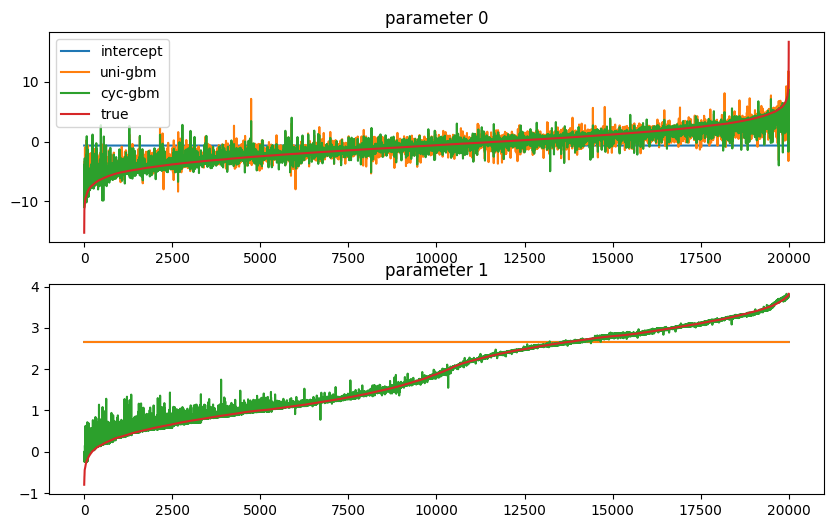

In [10]:
# Tuning results
kappas = pd.DataFrame(
    columns=[f"kappa_{j}" for j in range(0, distribution.d)],
    index=["uni-gbm", "cyc-gbm"],
    dtype=int,
)
kappas.loc["uni-gbm", :] = kappa_uni
kappas.loc["cyc-gbm", :] = kappa_cyc

print("boosting steps:")
print(kappas.astype(int))

# Losses
losses = pd.DataFrame(
    columns=["train", "test"],
    index=["intercept", "uni-gbm", "cyc-gbm", "true"],
    dtype=float,
)
for data_set, y_set in [("train", y_train), ("test", y_test)]:
    for model in z_hat[data_set].keys():
        losses.loc[model, data_set] = distribution.loss(
            y=y_set, z=z_hat[data_set][model]
        ).mean()
print("\nlosses:")
print(losses.round(3))

# Plot parameter estimates
fig, axs = plt.subplots(distribution.d, 1, figsize=(10, int(3 * distribution.d)))
axs = axs.flatten()

for j in range(distribution.d):
    axs[j].set_title(f"parameter {j}")
    sort_order = np.argsort(z_hat["test"]['true'][j])
    for model in ['intercept', 'uni-gbm', 'cyc-gbm', 'true']:
        axs[j].plot(z_hat["test"][model][j][sort_order], label=model)

axs[0].legend();
